In [57]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib as plt
import glob
import re
import cartopy

ModuleNotFoundError: No module named 'cartopy'

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [44]:
# Boulder Lat Lon
boulder_lat = 40.014
boulder_lon = -105.270 + 360
#
# Bounding box for Colorado
colorado_right  =  -109.060253 + 360
colorado_left   = -102.041524 + 360 
colorado_bottom = 37
colorado_top    = 41

In [4]:
# File paths
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_data    = '/gpfs/csfs1/collections/rda/data/'
era5_path   = rda_data + 'ds633.0/e5.oper.an.sfc/'
zarr_path   = rda_scratch + '/tas_zarr/'

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '2:30:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/work/harshah/conda-envs/zarr_experiments/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44265 instead
  warnings.warn(


In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/44265/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/44265/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.119:41219,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/44265/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
cluster.scale(2)

In [9]:
cluster

PBSCluster(bdbe3ba4, 'tcp://128.117.208.119:41219', workers=1, threads=1, memory=8.00 GiB)

### Compute JJA anomaly for 1994-2023 w.r.t 1940-1969 for a lat-lon grid which bounds Colorado

In [39]:
%%time
tas_daily_zarr      = xr.open_zarr(zarr_path +'e5_tas2m_daily_1940_2023.zarr').VAR_2T
tas_daily_zarr

CPU times: user 3.13 ms, sys: 3.41 ms, total: 6.53 ms
Wall time: 8.06 ms


<xarray.DataArray 'VAR_2T' (time: 30712, latitude: 721, longitude: 1440)> Size: 128GB
dask.array<open_dataset-VAR_2T, shape=(30712, 721, 1440), dtype=float32, chunksize=(1000, 139, 544), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 246kB 1940-01-01 1940-01-02 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [46]:
tas_daily_zarr      = tas_daily_zarr.sel(latitude=slice(colorado_top,colorado_bottom),\
                                         longitude=slice(colorado_right,colorado_left))
tas_daily_zarr 

<xarray.DataArray 'VAR_2T' (time: 30712, latitude: 17, longitude: 28)> Size: 58MB
dask.array<getitem, shape=(30712, 17, 28), dtype=float32, chunksize=(1000, 17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8
  * time       (time) datetime64[ns] 246kB 1940-01-01 1940-01-02 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [12]:
# %%time
# tas_daily_nc  = xr.open_mfdataset(zarr_path +'e5_tas2m_daily_1940_2023.nc',engine='netcdf4',chunks='auto').VAR_2T
# tas_daily_nc  = tas_daily_nc.sel(lat=boulder_lat,lon=boulder_lon,method='nearest')
# tas_daily_nc

#### Now compute monthly anomaly for JJA and comapre zarr vs netcdf

In [13]:
months = [6,7,8]

In [48]:
%%time
jja_tas_zarr = tas_daily_zarr.sel(time=tas_daily_zarr['time'].dt.month.isin(months))
#jja_tas_zarr

CPU times: user 4.55 ms, sys: 0 ns, total: 4.55 ms
Wall time: 8.46 ms


In [52]:
%%time
baseline_period = np.arange(1940,1970)
current_period  = np.arange(1994,2024)
#
jja_baseline    = jja_tas_zarr.sel(time = jja_tas_zarr['time'].dt.year.isin(baseline_period))
jja_current     = jja_tas_zarr.sel(time = jja_tas_zarr['time'].dt.year.isin(current_period))
#
jja_anomaly     = jja_current.mean('time') - jja_baseline.mean('time')
jja_anomaly

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 12.5 ms


<xarray.DataArray 'VAR_2T' (latitude: 17, longitude: 28)> Size: 2kB
dask.array<sub, shape=(17, 28), dtype=float32, chunksize=(17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8

In [53]:
%%time
## Generate performance report
with performance_report(filename ='zarr_jja_anomaly.html'):
     jja_anomaly.to_dataset().to_zarr(zarr_path + 'e5_jja_anomaly.zarr')

CPU times: user 987 ms, sys: 33.7 ms, total: 1.02 s
Wall time: 10.1 s


In [24]:
# %%time
# ## Generate performance report
# with performance_report(filename ='nc_jja_anomaly.html'):
#      jja_anomaly.to_dataset().to_netcdf(zarr_path + 'e5_jja_anomaly.nc')

CPU times: user 474 ms, sys: 24.8 ms, total: 498 ms
Wall time: 4.39 s


## Plotting

CPU times: user 333 ms, sys: 76.7 ms, total: 410 ms
Wall time: 4.24 s


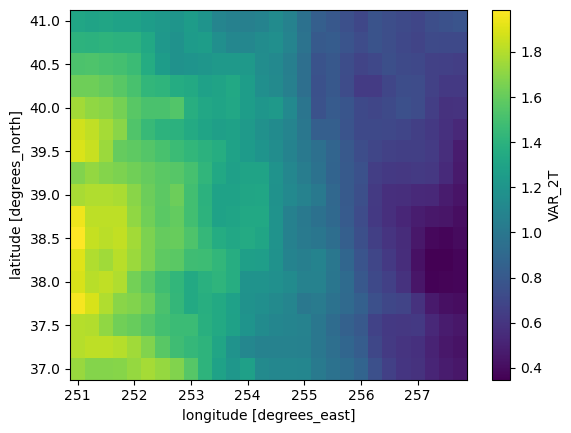

In [56]:
%%time
jja_anomaly =xr.open_zarr(zarr_path + 'e5_jja_anomaly.zarr').VAR_2T
jja_anomaly.plot()